In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_recall_fscore_support
import tensorflow as tf 
import tensorflow_addons as tfa
from models import ResNet50
sns.set_style("darkgrid")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [2]:
df = pd.read_csv('archive\metadata - standardized.csv')
df = pd.DataFrame(df[['names','types']])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   names   12449 non-null  object
 1   types   12449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 194.6+ KB


In [4]:
df.isnull().sum()

names    0
types    0
dtype: int64

In [5]:
df = df[df['types'] != -1]

0    7549
1    4767
Name: types, dtype: int64


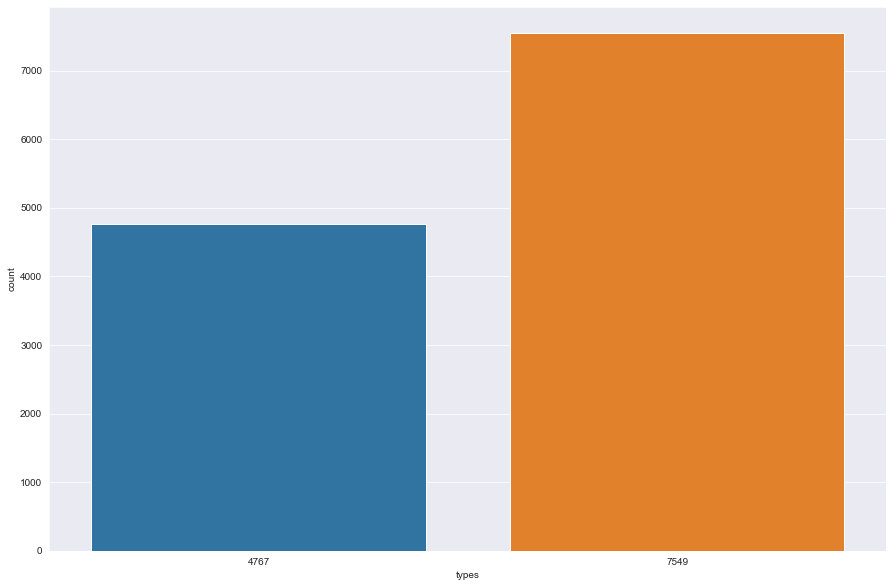

In [6]:
print(df['types'].value_counts())
fig = plt.figure(figsize=(15,10))
sns.countplot(df['types'].value_counts(), x=df['types'])
plt.show()

In [7]:
image_directory = r'archive\full-fundus\full-fundus'
image_size = 256
seed = 24
batch_size = 32

def get_path(name):
    return image_directory + '\\' + name + '.png'

df['path'] = df['names'].apply(get_path)
df.drop('names', axis=1, inplace=True)

In [8]:
train_data, val_data = train_test_split(df, test_size=0.2, random_state=seed)
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=seed)

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8866 entries, 715 to 1024
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   8866 non-null   int64 
 1   path    8866 non-null   object
dtypes: int64(1), object(1)
memory usage: 207.8+ KB


In [10]:
val_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2464 entries, 7492 to 1896
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   2464 non-null   int64 
 1   path    2464 non-null   object
dtypes: int64(1), object(1)
memory usage: 57.8+ KB


In [11]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986 entries, 3280 to 8590
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   types   986 non-null    int64 
 1   path    986 non-null    object
dtypes: int64(1), object(1)
memory usage: 23.1+ KB


In [12]:
class ImageGenerator(tf.keras.utils.Sequence):
    """
    Custom Image data generator class from Image paths and labels
    """
    def __init__(self, data: pd.DataFrame, batch_size: int=batch_size, image_size: tuple=image_size, balance: bool=False, augment: bool=False):
        if balance:
            self.data = self.__balance__(data)
        else:
            self.data = data
        self.labels = self.data['types'].values
        self.image_path = self.data['path'].values
        self.batch_size = batch_size
        self.image_size = (image_size, image_size)
        self.augment = augment
        self.augment_pipe = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
            tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
            tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
            tf.keras.layers.experimental.preprocessing.RandomTranslation(0.2, 0.2)
        ])
    
    def __augment__(self, image):
        if np.random.rand() > 0.6:
            image = self.augment_pipe(image)
        return image

    def __balance__(self, data):
        data_pos, data_neg = data[data['types'] == 1], data[data['types'] == 0]
        data_neg = data_neg.sample(len(data_pos), replace=False, random_state=seed)
        data = pd.concat([data_pos, data_neg])
        data = data.sample(frac=1)
        return data
    
    def __len__(self):
        return np.math.ceil(len(self.image_path) / self.batch_size)

    def __get_image__(self, image_path):
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=self.image_size)
        image = tf.keras.preprocessing.image.img_to_array(image)
        return image
    
    def __getitem__(self, index):

        batch_images = self.image_path[index * self.batch_size : (index + 1) * self.batch_size]
        batch_images = np.array([self.__augment__(self.__get_image__(path)) for path in batch_images]) / 255.0
        batch_labels = self.labels[index * self.batch_size : (index + 1) * self.batch_size]
        return batch_images, batch_labels

In [13]:
train_dataset = ImageGenerator(train_data, balance=True, augment=True)
val_dataset = ImageGenerator(val_data, balance=False, augment=False)
test_dataset = ImageGenerator(test_data, balance=False, augment=False)

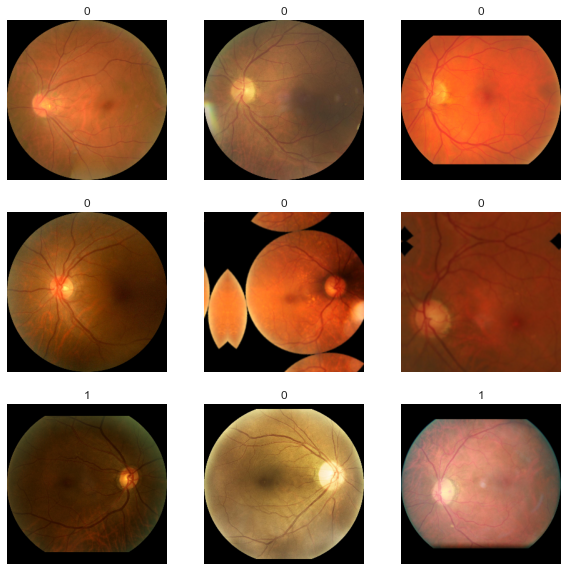

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
im,l = train_dataset.__getitem__(np.random.randint(0, len(train_dataset)))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(im[i])
  plt.title(l[i])
  plt.axis("off")

## ResNet50 Model

### Initializing

#### Hyperparameters

In [15]:
learning_rate = 0.001
weight_decay = 0.0002
beta = 0.9
num_epochs = 50
checkpoint_filepath_res = r'saved_model\resnet\weights.h5'

#### Evaluator

In [16]:
def run_evalutation(model, dataset):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, 
        weight_decay=weight_decay, 
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[
           'accuracy',
        ],
    )
    model.load_weights(checkpoint_filepath_res)
    _, accuracy = model.evaluate(dataset)
    predictions = model.predict(dataset)
    predictions = tf.where(predictions < 0.5, 0, 1)
    report  = classification_report(dataset.labels, predictions)
    return accuracy, report


### Building the Model

In [17]:
tf.keras.backend.clear_session()
res_classifier = ResNet50(input_shape=(image_size, image_size, 3), num_classes=1).build_model()

### Evaluation

31/31 [==============================] - 26s 850ms/step
Accuracy on test dataset:  0.7576065063476562
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.75      0.79       589
           1       0.68      0.80      0.73       397

    accuracy                           0.77       986
   macro avg       0.76      0.77      0.76       986
weighted avg       0.78      0.77      0.77       986

Confusion matrix:



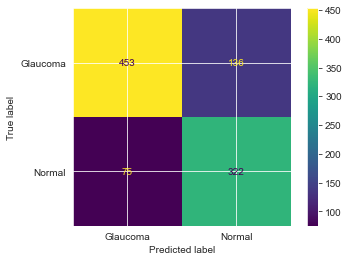

In [18]:
accuracy, report = run_evalutation(res_classifier, test_dataset)
pred_label = res_classifier.predict(test_dataset) > 0.5
precision,recall,f1_score,_ =  precision_recall_fscore_support(test_dataset.labels, pred_label, average='macro')
cm = confusion_matrix(test_dataset.labels, pred_label)
print("Accuracy on test dataset: ", accuracy)
print("Classification report:\n", report)
print("Confusion matrix:\n")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Glaucoma', 'Normal'])
disp.plot()

### Generating the Heatmap (Generates random heatmap from test dataset)

1/1 [==============================] - 0s 37ms/step
Predicted label: [[0.]] 
Actual label: 0


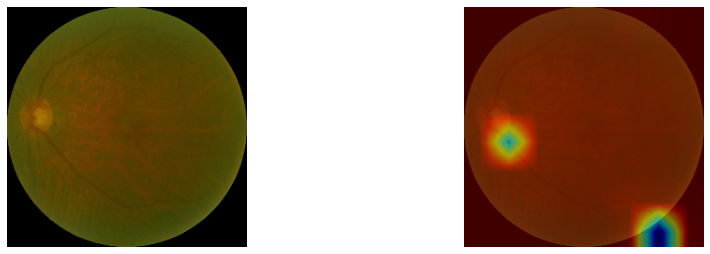

1/1 [==============================] - 0s 38ms/step
Predicted label: [[1.]] 
Actual label: 1


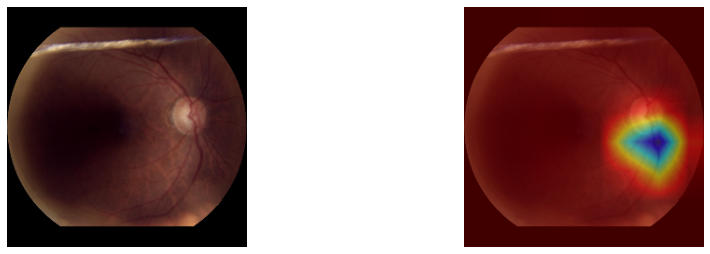

1/1 [==============================] - 0s 39ms/step
Predicted label: [[1.]] 
Actual label: 1


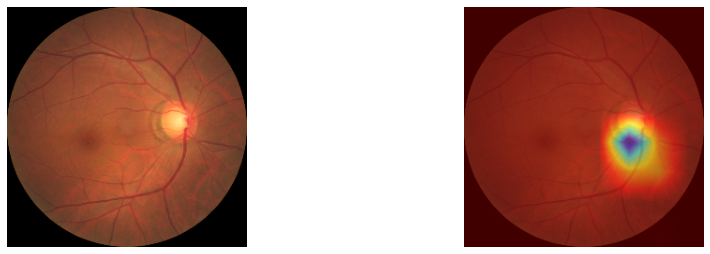

In [20]:
from cam import GRADgen
res_classifier.load_weights(checkpoint_filepath_res)
for i in range(3):
    random_batch = np.random.randint(0, 10)
    random_index = np.random.randint(0, 32)
    output, image, preds = GRADgen(res_classifier, 'conv5_block3_out', test_dataset.__getitem__(random_batch)[0][random_index])
    print(f"Predicted label: {preds} \nActual label: {test_dataset.__getitem__(random_batch)[1][random_index]}")
    fig = plt.figure(figsize=(15, 15))
    plt.subplot(3, 2, 2*i+1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(3, 2, 2*i+2)
    plt.imshow(output)
    plt.axis('off')
    plt.show()
